# Wavenumber-based Filtering with a Hann Window

When encountering a wave signal, we are not always interested in its phase signal. In case of wave packets we might want to identify the packet as a compact object, discounting the phase information. One way to remove phase information from a wave-like signal is by convolution with an appropriately-chosen window function.

Here, we review how the width of a Hann window should relate to the wavenumber of a wave-like signal in order to effectively remove its phase information. We focus on the filtering of finite-amplitude local wave activity (FALWA), as was previously done by Ghinassi et al. (2018, 2020).

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import barotropic as bt

## Setup

In [2]:
grid = bt.Grid(resolution=1.25)

Prescribe a large wavenumber 4 packet in the northern hemisphere midlatitudes.

In [3]:
rv = (2.0e-5 * np.sin(4 * grid.lam)
             * np.exp(-3.0e-5*(grid.lon2 - 180)**2)
             * np.exp(-0.01*(grid.lat2 - 45)**2))

Add planetary and relative vorticity and create a `barotropic.State` from the resulting absolute (=potential) vorticity, which allows for easy calculation of winds and FALWA.

In [4]:
pv = grid.coriolis(grid.lat2) + rv
state = bt.State(grid, time=0, pv=pv)

We only need a single zonal slice through the wave packet to illustrate filtering. Extract the meridional wind and FALWA at 45°N:

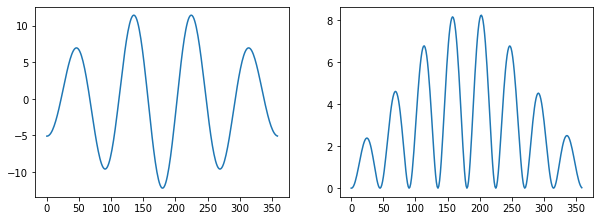

In [5]:
lat45 = np.isclose(grid.lat2, 45)
v45   = state.v[lat45]
lwa45 = state.falwa[lat45]

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
for ax, f in zip(axs, [v45, lwa45]):
    ax.plot(grid.lon, f)

We can see the wavepacket in the meridional wind (left) and FALWA (right). Counting the maxima in the meridional wind, we find the same wavenumber 4 that was prescribed in the relative vorticity. FALWA displays a wavenumber 8 pattern.


## Fourier Analysis

Based on the location of the maximum in the Fourier power spectrum of the zonal slice, we can find the dominant wavenumber. Wavenumber 0 is ignored (there is no "phase" to filter there).

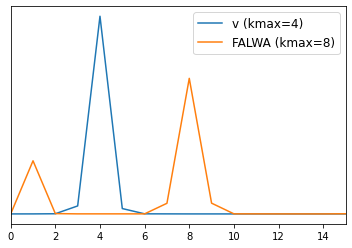

In [6]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

# Normalize the signals to remove the wavenumber 0 contribution
# and allow the power spectra to be displayed together in a plot
pwr_v   = np.abs(np.fft.rfft(normalize(v45)))**2
pwr_lwa = np.abs(np.fft.rfft(normalize(lwa45)))**2

plt.plot(pwr_v, label="v (kmax={})".format(np.argmax(pwr_v)))
plt.plot(pwr_lwa, label="FALWA (kmax={})".format(np.argmax(pwr_lwa)))
plt.yticks([])
plt.xlim(0, 15)
plt.legend(fontsize="large");

As expected, we obtain a dominant wavenumber of 4 for the meridional wind (v) and 8 for the FALWA.


## Implications for Hann-Window Filtering

The wavelength `l` corresponding to wavenumber `k` at latitude `ϕ` is given by the circumference of the zonal circle at `ϕ` divided by the wavenumber, i.e.

    l(ϕ, k) = 2πa cos(ϕ) / k

where `a` is the radius of the sphere. The Hann window is defined by

    H(x) = 0.5 + 0.5 * cos(x)

for `x` in `[-π, π]`. The window is then scaled to a given width `w`. We set the width of a Hann window at latitude `ϕ` corresponding to wavenumber `k` equal to twice the wavelength corresponding to `k`:

    w = 2 l(ϕ, k)

Often the width of a window is reported as its full width at half maximum (FWHM), which for the Hann window is

    FWHM = 0.5 w = l

In [7]:
def filter_hann(f, k):
    """"""
    # The argument of scipy.signal.windows.hann specifies
    # the full width of the filter as the number of gridpoints
    hann = signal.windows.hann(2 * len(f) // k)
    # Normalize the window
    hann /= np.sum(hann)
    # Use convolve2d which offers option of periodic boundary
    return signal.convolve2d([f], [hann], mode="same", boundary="wrap")[0]

Let's compare how well windows of different widths filter the phase of a signal:

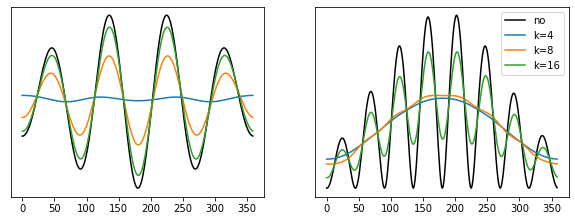

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

for ax, f in zip(axs, [v45, lwa45]):
    ax.plot(grid.lon, f, label="no", color="k")
    ax.plot(grid.lon, filter_hann(f,  4), label="k=4")
    ax.plot(grid.lon, filter_hann(f,  8), label="k=8")
    ax.plot(grid.lon, filter_hann(f, 16), label="k=16")
    ax.set_yticks([])

axs[-1].legend(loc="upper right");

We find for the different filter widths:

- `k =  4` (dominant wavenumber of v): removes the phase of both v and FALWA
- `k =  8` (dominant wavenumber of FALWA): removes the phase of FALWA but not of v
- `k = 16`: does not remove the phase of v or FALWA

This leads to the following conclusions:

- The wavelength corresponding to the dominant wavenumber `k` should determine **half** the width of the Hann window to ensure that the phase is removed adequately. This is how we defined the wavenumber-FWHM relation above..
- When filtering FALWA based on the dominant wavenumber of the meridional wind (as done by Ghinassi et al. 2018, 2020), the wavelength corresponding to the v-based dominant wavenumber should determine the **full** width of the Hann window because the wavenumber of FALWA is (generally speaking) twice that of the meridional wind. The phase is also removed if v determines the half width but the amplitude is damped stronger than necessary.
- If we are interested in the amplitude of a signal, a Hann-based filter can work for signals with a "directional" amplitude (like non-negative FALWA) but not signals like the meridional wind where amplitude varies in both directions from positive to negative. As seen above, the filter will remove both the amplitude and phase information for such signals. A Hilbert transform-based filter as proposed e.g. by Zimin et al. (2003) is more appropriate for such applications.


## Related Functions in `barotropic`

- Hann-window filtering based on a given wavenumber: `barotropic.diagnostic.filter_by_wavenumber`
- Extracting a local dominant wavenumber with a wavelet transform: `barotropic.diagnostic.dominant_wavenumber`
- Hilbert transform filter for the envelope of a wave packet: `barotropic.diagnostic.envelope_hilbert`


## References

- Ghinassi, P., Baumgart, M., Teubler, F., Riemer, M., & Wirth, V. (2020). [A Budget Equation for the Amplitude of Rossby Wave Packets Based on Finite-Amplitude Local Wave Activity](https://doi.org/10.1175/JAS-D-19-0149.1). *Journal of the Atmospheric Sciences*, 77(1), 277–296.
- Ghinassi, P., Fragkoulidis, G., & Wirth, V. (2018). [Local Finite-Amplitude Wave Activity as a Diagnostic for Rossby Wave Packets](https://doi.org/10.1175/MWR-D-18-0068.1). *Monthly Weather Review*, 146(12), 4099–4114.
- Zimin, A. V., Szunyogh, I., Patil, D. J., Hunt, B. R., & Ott, E. (2003). [Extracting Envelopes of Rossby Wave Packets](https://doi.org/10.1175/1520-0493%282003%29131%3C1011:EEORWP%3E2.0.CO;2). *Monthly Weather Review*, 131(5), 1011–1017.
